In [1]:
import gc
import os
import random
import csv
import sys
import json
import datetime

import lightgbm as lgb
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter
from numba import jit
#最大表示列数の指定（ここでは50列を指定）
pd.set_option('display.max_rows', 300)
#最大表示列数の指定（ここでは50列を指定）
pd.set_option('display.max_columns', 300)

from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import log_loss
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn import metrics
from tqdm import tqdm

plt.style.use("seaborn")
sns.set(font_scale=1)

teams = pd.read_csv("../input/google-cloud-ncaa-march-madness-2020-division-1-mens-tournament/MDataFiles_Stage1/MNCAATourneySeeds.csv")
tourney_compact = pd.read_csv("../input/google-cloud-ncaa-march-madness-2020-division-1-mens-tournament/MDataFiles_Stage1/MNCAATourneyCompactResults.csv")
regular_compact = pd.read_csv("../input/google-cloud-ncaa-march-madness-2020-division-1-mens-tournament/MDataFiles_Stage1/MRegularSeasonCompactResults.csv")
second_compact = pd.read_csv("../input/google-cloud-ncaa-march-madness-2020-division-1-mens-tournament/MDataFiles_Stage1/MSecondaryTourneyCompactResults.csv")
rank = pd.read_csv("../input/google-cloud-ncaa-march-madness-2020-division-1-mens-tournament/MDataFiles_Stage1/MMasseyOrdinals.csv")
sample_submission = pd.read_csv("../input/google-cloud-ncaa-march-madness-2020-division-1-mens-tournament/MSampleSubmissionStage1_2020.csv")

In [2]:
teams

,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374
...,...,...,...
2281,2019,Z12,1332
2282,2019,Z13,1414
2283,2019,Z14,1330
2284,2019,Z15,1159


In [3]:
teams_1ago = teams.copy()
teams_1ago.Season = teams_1ago.Season + 1
teams_1ago.Seed = teams_1ago.Seed.apply(lambda x: x[1:3]).astype(int)

In [4]:
t = teams.loc[:,["Season","TeamID"]]
t = t.merge(t,on="Season",how="outer")
t = t[t.TeamID_x < t.TeamID_y]
t = t.rename(columns={"TeamID_x":"TeamID_Low","TeamID_y":"TeamID_High"})
t[t.Season==2015]

,Season,TeamID_Low,TeamID_High
126283,2015,1437,1438
126294,2015,1437,1461
126320,2015,1437,1452
126322,2015,1437,1455
126333,2015,1437,1458
...,...,...,...
130900,2015,1157,1279
130901,2015,1157,1459
130902,2015,1157,1217
130903,2015,1157,1209


In [5]:
tourney_compact

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,136,1116,63,1234,54,N,0
1,1985,136,1120,59,1345,58,N,0
2,1985,136,1207,68,1250,43,N,0
3,1985,136,1229,58,1425,55,N,0
4,1985,136,1242,49,1325,38,N,0
...,...,...,...,...,...,...,...,...
2246,2019,146,1120,77,1246,71,N,1
2247,2019,146,1277,68,1181,67,N,0
2248,2019,152,1403,61,1277,51,N,0
2249,2019,152,1438,63,1120,62,N,0


In [6]:
train_pred = tourney_compact.merge(teams,left_on=["Season","WTeamID"], right_on=["Season", "TeamID"],how="left")
train_pred = train_pred.merge(teams,left_on=["Season","LTeamID"], right_on=["Season", "TeamID"],how="left")

train_pred["TeamID_Low"] = train_pred.loc[:,["WTeamID","LTeamID"]].min(axis=1)
train_pred["TeamID_High"] = train_pred.loc[:,["WTeamID","LTeamID"]].max(axis=1)
train_pred.loc[train_pred.TeamID_Low == train_pred.WTeamID, "Seed_Low"] = train_pred[train_pred.TeamID_Low == train_pred.WTeamID].Seed_x.apply(lambda x: x[1:3]).astype(int)
train_pred.loc[train_pred.TeamID_Low == train_pred.LTeamID, "Seed_Low"] = train_pred[train_pred.TeamID_Low == train_pred.LTeamID].Seed_y.apply(lambda x: x[1:3]).astype(int)
train_pred.loc[train_pred.TeamID_High == train_pred.WTeamID, "Seed_High"] = train_pred[train_pred.TeamID_High == train_pred.WTeamID].Seed_x.apply(lambda x: x[1:3]).astype(int)
train_pred.loc[train_pred.TeamID_High == train_pred.LTeamID, "Seed_High"] = train_pred[train_pred.TeamID_High == train_pred.LTeamID].Seed_y.apply(lambda x: x[1:3]).astype(int)
train_pred.loc[train_pred.TeamID_High == train_pred.WTeamID, "target"] = 0
train_pred.loc[train_pred.TeamID_High == train_pred.LTeamID, "target"] = 1
train_pred["Seed_dif"] = train_pred.Seed_Low - train_pred.Seed_High
train_pred["Seed_div"] = train_pred.Seed_Low / train_pred.Seed_High

train_pred = train_pred.loc[:,["TeamID_Low","TeamID_High","Season","Seed_Low","Seed_High","Seed_dif","Seed_div","target"]]
train_pred = train_pred.merge(teams_1ago,left_on=["Season","TeamID_Low"],right_on=["Season","TeamID"],how="left")
train_pred = train_pred.merge(teams_1ago,left_on=["Season","TeamID_High"],right_on=["Season","TeamID"],how="left")
train_pred.drop(["TeamID_x","TeamID_y"],axis=1,inplace=True)
train_pred = train_pred.rename(columns={"Seed_x":"Seed_1ago_Low","Seed_y":"Seed_1ago_High"})
train_pred = train_pred[train_pred.Season >= 1986]
train_pred["Seed_prog_Low"] = train_pred.Seed_Low - train_pred.Seed_1ago_Low
train_pred["Seed_prog_High"] = train_pred.Seed_High - train_pred.Seed_1ago_High
train_pred

,TeamID_Low,TeamID_High,Season,Seed_Low,Seed_High,Seed_dif,Seed_div,target,Seed_1ago_Low,Seed_1ago_High,Seed_prog_Low,Seed_prog_High
63,1133,1431,1986,7.0,10.0,-3.0,0.700000,1.0,NaN,11.0,NaN,-1.0
64,1177,1438,1986,12.0,5.0,7.0,2.400000,1.0,10.0,NaN,2.0,NaN
65,1181,1290,1986,1.0,16.0,-15.0,0.062500,1.0,3.0,NaN,-2.0,NaN
66,1207,1403,1986,4.0,13.0,-9.0,0.307692,1.0,1.0,6.0,3.0,7.0
67,1210,1265,1986,2.0,15.0,-13.0,0.133333,1.0,2.0,NaN,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2246,1120,1246,2019,5.0,2.0,3.0,2.500000,1.0,4.0,5.0,1.0,-3.0
2247,1181,1277,2019,1.0,2.0,-1.0,0.500000,0.0,2.0,3.0,-1.0,-1.0
2248,1277,1403,2019,2.0,3.0,-1.0,0.666667,0.0,3.0,3.0,-1.0,0.0
2249,1120,1438,2019,5.0,1.0,4.0,5.000000,0.0,4.0,1.0,1.0,0.0


In [7]:
test = t.copy().merge(teams,left_on=["Season","TeamID_Low"], right_on=["Season", "TeamID"],how="left")
test = test.merge(teams,left_on=["Season","TeamID_High"], right_on=["Season", "TeamID"],how="left")
test.loc[:,"Seed_x"] = test.Seed_x.apply(lambda x: x[1:3]).astype(int)
test.loc[:,"Seed_y"] = test.Seed_y.apply(lambda x: x[1:3]).astype(int)
test = test.rename(columns={"Seed_x":"Seed_Low","Seed_y":"Seed_High"})
test["Seed_dif"] = test.Seed_Low - test.Seed_High
test["Seed_div"] = test.Seed_Low / test.Seed_High
test= test.loc[:,["TeamID_Low","TeamID_High","Season","Seed_Low","Seed_dif","Seed_div","Seed_High"]]
test = test.merge(teams_1ago,left_on=["Season","TeamID_Low"],right_on=["Season","TeamID"],how="left")
test = test.merge(teams_1ago,left_on=["Season","TeamID_High"],right_on=["Season","TeamID"],how="left")
test.drop(["TeamID_x","TeamID_y"],axis=1,inplace=True)
test = test.rename(columns={"Seed_x":"Seed_1ago_Low","Seed_y":"Seed_1ago_High"})
test["Seed_prog_Low"] = test.Seed_Low - test.Seed_1ago_Low
test["Seed_prog_High"] = test.Seed_High - test.Seed_1ago_High
test[test.Season>=2015]

,TeamID_Low,TeamID_High,Season,Seed_Low,Seed_dif,Seed_div,Seed_High,Seed_1ago_Low,Seed_1ago_High,Seed_prog_Low,Seed_prog_High
62168,1437,1438,2015,1,-1,0.500000,2,2.0,1.0,-1.0,1.0
62169,1437,1461,2015,1,-11,0.083333,12,2.0,NaN,-1.0,NaN
62170,1437,1452,2015,1,-4,0.200000,5,2.0,NaN,-1.0,NaN
62171,1437,1455,2015,1,-6,0.142857,7,2.0,1.0,-1.0,6.0
62172,1437,1458,2015,1,0,1.000000,1,2.0,2.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...
73553,1205,1234,2019,16,6,1.600000,10,NaN,NaN,NaN,NaN
73554,1205,1388,2019,16,5,1.454545,11,NaN,NaN,NaN,NaN
73555,1205,1332,2019,16,4,1.333333,12,NaN,NaN,NaN,NaN
73556,1205,1414,2019,16,3,1.230769,13,NaN,NaN,NaN,NaN


In [8]:
regular_compact.groupby(["Season","WTeamID"]).mean().reset_index()

,Season,WTeamID,DayNum,WScore,LTeamID,LScore,NumOT
0,1985,1102,86.000000,71.000000,1230.600000,61.000000,0.0
1,1985,1103,85.000000,70.222222,1288.222222,62.666667,0.0
2,1985,1104,79.761905,72.095238,1276.047619,58.904762,0.0
3,1985,1106,88.100000,75.100000,1311.800000,65.600000,0.0
4,1985,1108,94.736842,85.842105,1286.105263,72.000000,0.0
...,...,...,...,...,...,...,...
11222,2019,1462,64.666667,76.944444,1262.166667,66.388889,0.0
11223,2019,1463,75.380952,83.761905,1215.476190,70.095238,0.0
11224,2019,1464,75.000000,78.100000,1285.300000,69.600000,0.0
11225,2019,1465,65.166667,80.083333,1302.083333,66.166667,0.0


In [9]:
train_pred = train_pred.merge(regular_compact.groupby(["Season","WTeamID"]).count().reset_index().loc[:,["Season","WTeamID","DayNum"]],left_on=["Season","TeamID_Low"],right_on=["Season","WTeamID"],how="left")
train_pred = train_pred.merge(regular_compact.groupby(["Season","WTeamID"]).count().reset_index().loc[:,["Season","WTeamID","DayNum"]],left_on=["Season","TeamID_High"],right_on=["Season","WTeamID"],how="left")
train_pred = train_pred.rename(columns={"DayNum_x":"Reg_Win_Low","DayNum_y":"Reg_Win_High"})
train_pred = train_pred.merge(regular_compact.groupby(["Season","LTeamID"]).count().reset_index().loc[:,["Season","LTeamID","DayNum"]],left_on=["Season","TeamID_Low"],right_on=["Season","LTeamID"],how="left")
train_pred = train_pred.merge(regular_compact.groupby(["Season","LTeamID"]).count().reset_index().loc[:,["Season","LTeamID","DayNum"]],left_on=["Season","TeamID_High"],right_on=["Season","LTeamID"],how="left")
train_pred = train_pred.rename(columns={"DayNum_x":"Reg_Lose_Low","DayNum_y":"Reg_Lose_High"})
train_pred.drop(["WTeamID_x","WTeamID_y","LTeamID_x","LTeamID_y"],axis=1,inplace=True)
train_pred["Reg_WinRate_Low"] = train_pred.Reg_Win_Low/(train_pred.Reg_Win_Low+train_pred.Reg_Lose_Low)
train_pred["Reg_WinRate_High"] = train_pred.Reg_Win_High/(train_pred.Reg_Win_High+train_pred.Reg_Lose_High)
train_pred["Reg_WinRate_div"] = train_pred.Reg_WinRate_Low / train_pred.Reg_WinRate_High

train_pred = train_pred.merge(regular_compact.groupby(["Season","WTeamID"]).sum().reset_index().loc[:,["Season","WTeamID","WScore"]],left_on=["Season","TeamID_Low"],right_on=["Season","WTeamID"],how="left")
train_pred = train_pred.merge(regular_compact.groupby(["Season","WTeamID"]).sum().reset_index().loc[:,["Season","WTeamID","WScore"]],left_on=["Season","TeamID_High"],right_on=["Season","WTeamID"],how="left")
train_pred = train_pred.rename(columns={"WScore_x":"Reg_WScore_Low","WScore_y":"Reg_WScore_High"})
train_pred = train_pred.merge(regular_compact.groupby(["Season","LTeamID"]).sum().reset_index().loc[:,["Season","LTeamID","LScore"]],left_on=["Season","TeamID_Low"],right_on=["Season","LTeamID"],how="left")
train_pred = train_pred.merge(regular_compact.groupby(["Season","LTeamID"]).sum().reset_index().loc[:,["Season","LTeamID","LScore"]],left_on=["Season","TeamID_High"],right_on=["Season","LTeamID"],how="left")
train_pred = train_pred.rename(columns={"LScore_x":"Reg_LScore_Low","LScore_y":"Reg_LScore_High"})
train_pred.drop(["WTeamID_x","WTeamID_y","LTeamID_x","LTeamID_y"],axis=1,inplace=True)

train_pred["Reg_Score_Low"] = (train_pred.Reg_WScore_Low + train_pred.Reg_LScore_Low) / (train_pred.Reg_Win_Low + train_pred.Reg_Lose_Low)
train_pred["Reg_Score_High"] = (train_pred.Reg_WScore_High + train_pred.Reg_LScore_High) / (train_pred.Reg_Win_High + train_pred.Reg_Lose_High)
train_pred["Reg_Score_div"] = train_pred.Reg_Score_Low / train_pred.Reg_Score_High

train_pred

,TeamID_Low,TeamID_High,Season,Seed_Low,Seed_High,Seed_dif,Seed_div,target,Seed_1ago_Low,Seed_1ago_High,Seed_prog_Low,Seed_prog_High,Reg_Win_Low,Reg_Win_High,Reg_Lose_Low,Reg_Lose_High,Reg_WinRate_Low,Reg_WinRate_High,Reg_WinRate_div,Reg_WScore_Low,Reg_WScore_High,Reg_LScore_Low,Reg_LScore_High,Reg_Score_Low,Reg_Score_High,Reg_Score_div
0,1133,1431,1986,7.0,10.0,-3.0,0.700000,1.0,NaN,11.0,NaN,-1.0,30,27,2.0,5.0,0.937500,0.843750,1.111111,2145,1845,134.0,317.0,71.218750,67.562500,1.054117
1,1177,1438,1986,12.0,5.0,7.0,2.400000,1.0,10.0,NaN,2.0,NaN,16,19,12.0,10.0,0.571429,0.655172,0.872180,1203,1412,737.0,631.0,69.285714,70.448276,0.983498
2,1181,1290,1986,1.0,16.0,-15.0,0.062500,1.0,3.0,NaN,-2.0,NaN,32,18,2.0,8.0,0.941176,0.692308,1.359477,2560,1370,172.0,518.0,80.352941,72.615385,1.106555
3,1207,1403,1986,4.0,13.0,-9.0,0.307692,1.0,1.0,6.0,3.0,7.0,20,16,7.0,13.0,0.740741,0.551724,1.342593,1591,1040,496.0,759.0,77.296296,62.034483,1.246021
4,1210,1265,1986,2.0,15.0,-13.0,0.133333,1.0,2.0,NaN,0.0,NaN,24,17,6.0,11.0,0.800000,0.607143,1.317647,1855,1180,381.0,694.0,74.533333,66.928571,1.113625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2183,1120,1246,2019,5.0,2.0,3.0,2.500000,1.0,4.0,5.0,1.0,-3.0,25,27,9.0,6.0,0.735294,0.818182,0.898693,2045,2089,637.0,443.0,78.882353,76.727273,1.028088
2184,1181,1277,2019,1.0,2.0,-1.0,0.500000,0.0,2.0,3.0,-1.0,-1.0,29,28,5.0,6.0,0.852941,0.823529,1.035714,2447,2241,392.0,439.0,83.500000,78.823529,1.059328
2185,1277,1403,2019,2.0,3.0,-1.0,0.666667,0.0,3.0,3.0,-1.0,0.0,28,26,6.0,6.0,0.823529,0.812500,1.013575,2241,1973,439.0,366.0,78.823529,73.093750,1.078389
2186,1120,1438,2019,5.0,1.0,4.0,5.000000,0.0,4.0,1.0,1.0,0.0,25,29,9.0,3.0,0.735294,0.906250,0.811359,2045,2099,637.0,200.0,78.882353,71.843750,1.097971


In [10]:
test = test.merge(regular_compact.groupby(["Season","WTeamID"]).count().reset_index().loc[:,["Season","WTeamID","DayNum"]],left_on=["Season","TeamID_Low"],right_on=["Season","WTeamID"],how="left")
test = test.merge(regular_compact.groupby(["Season","WTeamID"]).count().reset_index().loc[:,["Season","WTeamID","DayNum"]],left_on=["Season","TeamID_High"],right_on=["Season","WTeamID"],how="left")
test = test.rename(columns={"DayNum_x":"Reg_Win_Low","DayNum_y":"Reg_Win_High"})
test = test.merge(regular_compact.groupby(["Season","LTeamID"]).count().reset_index().loc[:,["Season","LTeamID","DayNum"]],left_on=["Season","TeamID_Low"],right_on=["Season","LTeamID"],how="left")
test = test.merge(regular_compact.groupby(["Season","LTeamID"]).count().reset_index().loc[:,["Season","LTeamID","DayNum"]],left_on=["Season","TeamID_High"],right_on=["Season","LTeamID"],how="left")
test = test.rename(columns={"DayNum_x":"Reg_Lose_Low","DayNum_y":"Reg_Lose_High"})
test.drop(["WTeamID_x","WTeamID_y","LTeamID_x","LTeamID_y"],axis=1,inplace=True)
test["Reg_WinRate_Low"] = test.Reg_Win_Low/(test.Reg_Win_Low+test.Reg_Lose_Low)
test["Reg_WinRate_High"] = test.Reg_Win_High/(test.Reg_Win_High+test.Reg_Lose_High)
test["Reg_WinRate_div"] = test.Reg_WinRate_Low / test.Reg_WinRate_High

test = test.merge(regular_compact.groupby(["Season","WTeamID"]).mean().reset_index().loc[:,["Season","WTeamID","WScore"]],left_on=["Season","TeamID_Low"],right_on=["Season","WTeamID"],how="left")
test = test.merge(regular_compact.groupby(["Season","WTeamID"]).mean().reset_index().loc[:,["Season","WTeamID","WScore"]],left_on=["Season","TeamID_High"],right_on=["Season","WTeamID"],how="left")
test = test.rename(columns={"WScore_x":"Reg_WScore_Low","WScore_y":"Reg_WScore_High"})
test = test.merge(regular_compact.groupby(["Season","LTeamID"]).mean().reset_index().loc[:,["Season","LTeamID","LScore"]],left_on=["Season","TeamID_Low"],right_on=["Season","LTeamID"],how="left")
test = test.merge(regular_compact.groupby(["Season","LTeamID"]).mean().reset_index().loc[:,["Season","LTeamID","LScore"]],left_on=["Season","TeamID_High"],right_on=["Season","LTeamID"],how="left")
test = test.rename(columns={"LScore_x":"Reg_LScore_Low","LScore_y":"Reg_LScore_High"})
test.drop(["WTeamID_x","WTeamID_y","LTeamID_x","LTeamID_y"],axis=1,inplace=True)

test["Reg_Score_Low"] = (test.Reg_WScore_Low + test.Reg_LScore_Low) // (test.Reg_Win_Low + test.Reg_Lose_Low)
test["Reg_Score_High"] = (test.Reg_WScore_High + test.Reg_LScore_High) // (test.Reg_Win_High + test.Reg_Lose_High)
test["Reg_Score_div"] = test.Reg_Score_Low / test.Reg_Score_High

test[test.Season>=2015]

,TeamID_Low,TeamID_High,Season,Seed_Low,Seed_dif,Seed_div,Seed_High,Seed_1ago_Low,Seed_1ago_High,Seed_prog_Low,Seed_prog_High,Reg_Win_Low,Reg_Win_High,Reg_Lose_Low,Reg_Lose_High,Reg_WinRate_Low,Reg_WinRate_High,Reg_WinRate_div,Reg_WScore_Low,Reg_WScore_High,Reg_LScore_Low,Reg_LScore_High,Reg_Score_Low,Reg_Score_High,Reg_Score_div
62168,1437,1438,2015,1,-1,0.500000,2,2.0,1.0,-1.0,1.0,32,29,2.0,3.0,0.941176,0.906250,1.038540,77.3125,65.655172,59.500000,62.333333,4.0,3.0,1.333333
62169,1437,1461,2015,1,-11,0.083333,12,2.0,NaN,-1.0,NaN,32,23,2.0,9.0,0.941176,0.718750,1.309463,77.3125,66.043478,59.500000,49.666667,4.0,3.0,1.333333
62170,1437,1452,2015,1,-4,0.200000,5,2.0,NaN,-1.0,NaN,32,23,2.0,9.0,0.941176,0.718750,1.309463,77.3125,77.652174,59.500000,64.444444,4.0,4.0,1.000000
62171,1437,1455,2015,1,-6,0.142857,7,2.0,1.0,-1.0,6.0,32,27,2.0,4.0,0.941176,0.870968,1.080610,77.3125,69.925926,59.500000,59.500000,4.0,4.0,1.000000
62172,1437,1458,2015,1,0,1.000000,1,2.0,2.0,-1.0,-1.0,32,31,2.0,3.0,0.941176,0.911765,1.032258,77.3125,72.870968,59.500000,61.666667,4.0,3.0,1.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73553,1205,1234,2019,16,6,1.600000,10,NaN,NaN,NaN,NaN,20,22,11.0,11.0,0.645161,0.666667,0.967742,77.6500,83.181818,72.363636,68.545455,4.0,4.0,1.000000
73554,1205,1388,2019,16,5,1.454545,11,NaN,NaN,NaN,NaN,20,22,11.0,11.0,0.645161,0.666667,0.967742,77.6500,76.590909,72.363636,65.545455,4.0,4.0,1.000000
73555,1205,1332,2019,16,4,1.333333,12,NaN,NaN,NaN,NaN,20,23,11.0,12.0,0.645161,0.657143,0.981767,77.6500,73.478261,72.363636,64.750000,4.0,3.0,1.333333
73556,1205,1414,2019,16,3,1.230769,13,NaN,NaN,NaN,NaN,20,29,11.0,5.0,0.645161,0.852941,0.756396,77.6500,73.793103,72.363636,64.800000,4.0,4.0,1.000000


In [11]:
rank.groupby(["Season","TeamID"]).mean()

RankingDayNum  OrdinalRank
Season TeamID                            
2003   1102        90.640000   144.287500
       1103        90.640000   182.205000
       1104        89.521531    27.655502
       1105        90.640000   305.377500
       1106        90.640000   243.265000
...                      ...          ...
2019   1462        83.553879    77.563578
       1463        83.646868    91.541037
       1464        83.646868   289.747300
       1465        83.470524   226.581878
       1466        83.513661   311.457923

[5834 rows x 2 columns]

In [12]:
train_pred = train_pred.merge(rank.groupby(["Season","TeamID"]).mean().reset_index().loc[:,["Season","TeamID","OrdinalRank"]],left_on=["Season","TeamID_Low"],right_on=["Season","TeamID"],how="left")
train_pred = train_pred.merge(rank.groupby(["Season","TeamID"]).mean().reset_index().loc[:,["Season","TeamID","OrdinalRank"]],left_on=["Season","TeamID_High"],right_on=["Season","TeamID"],how="left")
train_pred.drop(["TeamID_x","TeamID_y"],axis=1,inplace=True)
train_pred = train_pred.rename(columns={"OrdinalRank_x":"Rank_Low","OrdinalRank_y":"Rank_High"})
train_pred = train_pred.merge(rank.groupby(["Season","TeamID"]).max().reset_index().loc[:,["Season","TeamID","OrdinalRank"]],left_on=["Season","TeamID_Low"],right_on=["Season","TeamID"],how="left")
train_pred = train_pred.merge(rank.groupby(["Season","TeamID"]).max().reset_index().loc[:,["Season","TeamID","OrdinalRank"]],left_on=["Season","TeamID_High"],right_on=["Season","TeamID"],how="left")
train_pred.drop(["TeamID_x","TeamID_y"],axis=1,inplace=True)
train_pred = train_pred.rename(columns={"OrdinalRank_x":"maxRank_Low","OrdinalRank_y":"maxRank_High"})
train_pred = train_pred.merge(rank.groupby(["Season","TeamID"]).min().reset_index().loc[:,["Season","TeamID","OrdinalRank"]],left_on=["Season","TeamID_Low"],right_on=["Season","TeamID"],how="left")
train_pred = train_pred.merge(rank.groupby(["Season","TeamID"]).min().reset_index().loc[:,["Season","TeamID","OrdinalRank"]],left_on=["Season","TeamID_High"],right_on=["Season","TeamID"],how="left")
train_pred.drop(["TeamID_x","TeamID_y"],axis=1,inplace=True)
train_pred = train_pred.rename(columns={"OrdinalRank_x":"minRank_Low","OrdinalRank_y":"minRank_High"})
train_pred["Rank_div"] = train_pred.Rank_Low / train_pred.Rank_High
train_pred["minRank_div"] = train_pred.minRank_Low / train_pred.minRank_High
train_pred["maxRank_div"] = train_pred.maxRank_Low / train_pred.maxRank_High

train_pred

,TeamID_Low,TeamID_High,Season,Seed_Low,Seed_High,Seed_dif,Seed_div,target,Seed_1ago_Low,Seed_1ago_High,Seed_prog_Low,Seed_prog_High,Reg_Win_Low,Reg_Win_High,Reg_Lose_Low,Reg_Lose_High,Reg_WinRate_Low,Reg_WinRate_High,Reg_WinRate_div,Reg_WScore_Low,Reg_WScore_High,Reg_LScore_Low,Reg_LScore_High,Reg_Score_Low,Reg_Score_High,Reg_Score_div,Rank_Low,Rank_High,maxRank_Low,maxRank_High,minRank_Low,minRank_High,Rank_div,minRank_div,maxRank_div
0,1133,1431,1986,7.0,10.0,-3.0,0.700000,1.0,NaN,11.0,NaN,-1.0,30,27,2.0,5.0,0.937500,0.843750,1.111111,2145,1845,134.0,317.0,71.218750,67.562500,1.054117,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1177,1438,1986,12.0,5.0,7.0,2.400000,1.0,10.0,NaN,2.0,NaN,16,19,12.0,10.0,0.571429,0.655172,0.872180,1203,1412,737.0,631.0,69.285714,70.448276,0.983498,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1181,1290,1986,1.0,16.0,-15.0,0.062500,1.0,3.0,NaN,-2.0,NaN,32,18,2.0,8.0,0.941176,0.692308,1.359477,2560,1370,172.0,518.0,80.352941,72.615385,1.106555,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1207,1403,1986,4.0,13.0,-9.0,0.307692,1.0,1.0,6.0,3.0,7.0,20,16,7.0,13.0,0.740741,0.551724,1.342593,1591,1040,496.0,759.0,77.296296,62.034483,1.246021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1210,1265,1986,2.0,15.0,-13.0,0.133333,1.0,2.0,NaN,0.0,NaN,24,17,6.0,11.0,0.800000,0.607143,1.317647,1855,1180,381.0,694.0,74.533333,66.928571,1.113625,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2183,1120,1246,2019,5.0,2.0,3.0,2.500000,1.0,4.0,5.0,1.0,-3.0,25,27,9.0,6.0,0.735294,0.818182,0.898693,2045,2089,637.0,443.0,78.882353,76.727273,1.028088,17.748713,15.207700,58.0,105.0,2.0,2.0,1.167087,1.0,0.552381
2184,1181,1277,2019,1.0,2.0,-1.0,0.500000,0.0,2.0,3.0,-1.0,-1.0,29,28,5.0,6.0,0.852941,0.823529,1.035714,2447,2241,392.0,439.0,83.500000,78.823529,1.059328,1.980769,6.603239,26.0,81.0,1.0,1.0,0.299969,1.0,0.320988
2185,1277,1403,2019,2.0,3.0,-1.0,0.666667,0.0,3.0,3.0,-1.0,0.0,28,26,6.0,6.0,0.823529,0.812500,1.013575,2241,1973,439.0,366.0,78.823529,73.093750,1.078389,6.603239,13.330275,81.0,69.0,1.0,1.0,0.495357,1.0,1.173913
2186,1120,1438,2019,5.0,1.0,4.0,5.000000,0.0,4.0,1.0,1.0,0.0,25,29,9.0,3.0,0.735294,0.906250,0.811359,2045,2099,637.0,200.0,78.882353,71.843750,1.097971,17.748713,3.682186,58.0,44.0,2.0,1.0,4.820156,2.0,1.318182


In [13]:
test = test.merge(rank.groupby(["Season","TeamID"]).mean().reset_index().loc[:,["Season","TeamID","OrdinalRank"]],left_on=["Season","TeamID_Low"],right_on=["Season","TeamID"],how="left")
test = test.merge(rank.groupby(["Season","TeamID"]).mean().reset_index().loc[:,["Season","TeamID","OrdinalRank"]],left_on=["Season","TeamID_High"],right_on=["Season","TeamID"],how="left")
test.drop(["TeamID_x","TeamID_y"],axis=1,inplace=True)
test = test.rename(columns={"OrdinalRank_x":"Rank_Low","OrdinalRank_y":"Rank_High"})
test = test.merge(rank.groupby(["Season","TeamID"]).max().reset_index().loc[:,["Season","TeamID","OrdinalRank"]],left_on=["Season","TeamID_Low"],right_on=["Season","TeamID"],how="left")
test = test.merge(rank.groupby(["Season","TeamID"]).max().reset_index().loc[:,["Season","TeamID","OrdinalRank"]],left_on=["Season","TeamID_High"],right_on=["Season","TeamID"],how="left")
test.drop(["TeamID_x","TeamID_y"],axis=1,inplace=True)
test = test.rename(columns={"OrdinalRank_x":"maxRank_Low","OrdinalRank_y":"maxRank_High"})
test = test.merge(rank.groupby(["Season","TeamID"]).min().reset_index().loc[:,["Season","TeamID","OrdinalRank"]],left_on=["Season","TeamID_Low"],right_on=["Season","TeamID"],how="left")
test = test.merge(rank.groupby(["Season","TeamID"]).min().reset_index().loc[:,["Season","TeamID","OrdinalRank"]],left_on=["Season","TeamID_High"],right_on=["Season","TeamID"],how="left")
test.drop(["TeamID_x","TeamID_y"],axis=1,inplace=True)
test = test.rename(columns={"OrdinalRank_x":"minRank_Low","OrdinalRank_y":"minRank_High"})
test["Rank_div"] = test.Rank_Low / test.Rank_High
test["minRank_div"] = test.minRank_Low / test.minRank_High
test["maxRank_div"] = test.maxRank_Low / test.maxRank_High

test

,TeamID_Low,TeamID_High,Season,Seed_Low,Seed_dif,Seed_div,Seed_High,Seed_1ago_Low,Seed_1ago_High,Seed_prog_Low,Seed_prog_High,Reg_Win_Low,Reg_Win_High,Reg_Lose_Low,Reg_Lose_High,Reg_WinRate_Low,Reg_WinRate_High,Reg_WinRate_div,Reg_WScore_Low,Reg_WScore_High,Reg_LScore_Low,Reg_LScore_High,Reg_Score_Low,Reg_Score_High,Reg_Score_div,Rank_Low,Rank_High,maxRank_Low,maxRank_High,minRank_Low,minRank_High,Rank_div,minRank_div,maxRank_div
0,1207,1210,1985,1,-1,0.500000,2,NaN,NaN,NaN,NaN,25,24,2.0,7.0,0.925926,0.774194,1.195988,76.68,73.083333,64.000000,63.428571,5.0,4.0,1.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1207,1228,1985,1,-2,0.333333,3,NaN,NaN,NaN,NaN,25,23,2.0,8.0,0.925926,0.741935,1.247987,76.68,73.217391,64.000000,53.875000,5.0,4.0,1.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1207,1260,1985,1,-3,0.250000,4,NaN,NaN,NaN,NaN,25,25,2.0,5.0,0.925926,0.833333,1.111111,76.68,86.800000,64.000000,81.000000,5.0,5.0,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1207,1374,1985,1,-4,0.200000,5,NaN,NaN,NaN,NaN,25,22,2.0,8.0,0.925926,0.733333,1.262626,76.68,78.772727,64.000000,68.250000,5.0,4.0,1.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1207,1208,1985,1,-5,0.166667,6,NaN,NaN,NaN,NaN,25,19,2.0,8.0,0.925926,0.703704,1.315789,76.68,81.105263,64.000000,69.250000,5.0,5.0,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73553,1205,1234,2019,16,6,1.600000,10,NaN,NaN,NaN,NaN,20,22,11.0,11.0,0.645161,0.666667,0.967742,77.65,83.181818,72.363636,68.545455,4.0,4.0,1.000000,182.88013,33.105046,305.0,153.0,3.0,3.0,5.524237,1.000000,1.993464
73554,1205,1388,2019,16,5,1.454545,11,NaN,NaN,NaN,NaN,20,22,11.0,11.0,0.645161,0.666667,0.967742,77.65,76.590909,72.363636,65.545455,4.0,4.0,1.000000,182.88013,56.774194,305.0,194.0,3.0,11.0,3.221184,0.272727,1.572165
73555,1205,1332,2019,16,4,1.333333,12,NaN,NaN,NaN,NaN,20,23,11.0,12.0,0.645161,0.657143,0.981767,77.65,73.478261,72.363636,64.750000,4.0,3.0,1.333333,182.88013,61.149573,305.0,162.0,3.0,7.0,2.990702,0.428571,1.882716
73556,1205,1414,2019,16,3,1.230769,13,NaN,NaN,NaN,NaN,20,29,11.0,5.0,0.645161,0.852941,0.756396,77.65,73.793103,72.363636,64.800000,4.0,4.0,1.000000,182.88013,92.139309,305.0,171.0,3.0,28.0,1.984822,0.107143,1.783626


In [14]:
train_pred = train_pred.merge(second_compact.groupby(["Season","WTeamID"]).count().reset_index().loc[:,["Season","WTeamID","DayNum"]],left_on=["Season","TeamID_Low"],right_on=["Season","WTeamID"],how="left")
train_pred = train_pred.merge(second_compact.groupby(["Season","WTeamID"]).count().reset_index().loc[:,["Season","WTeamID","DayNum"]],left_on=["Season","TeamID_High"],right_on=["Season","WTeamID"],how="left")
train_pred = train_pred.rename(columns={"DayNum_x":"Sec_Win_Low","DayNum_y":"Sec_Win_High"})
train_pred.drop(["WTeamID_x","WTeamID_y"],axis=1,inplace=True)
train_pred.head(100)

,TeamID_Low,TeamID_High,Season,Seed_Low,Seed_High,Seed_dif,Seed_div,target,Seed_1ago_Low,Seed_1ago_High,Seed_prog_Low,Seed_prog_High,Reg_Win_Low,Reg_Win_High,Reg_Lose_Low,Reg_Lose_High,Reg_WinRate_Low,Reg_WinRate_High,Reg_WinRate_div,Reg_WScore_Low,Reg_WScore_High,Reg_LScore_Low,Reg_LScore_High,Reg_Score_Low,Reg_Score_High,Reg_Score_div,Rank_Low,Rank_High,maxRank_Low,maxRank_High,minRank_Low,minRank_High,Rank_div,minRank_div,maxRank_div,Sec_Win_Low,Sec_Win_High
0,1133,1431,1986,7.0,10.0,-3.0,0.700000,1.0,NaN,11.0,NaN,-1.0,30,27,2.0,5.0,0.937500,0.843750,1.111111,2145,1845,134.0,317.0,71.218750,67.562500,1.054117,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1177,1438,1986,12.0,5.0,7.0,2.400000,1.0,10.0,NaN,2.0,NaN,16,19,12.0,10.0,0.571429,0.655172,0.872180,1203,1412,737.0,631.0,69.285714,70.448276,0.983498,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1181,1290,1986,1.0,16.0,-15.0,0.062500,1.0,3.0,NaN,-2.0,NaN,32,18,2.0,8.0,0.941176,0.692308,1.359477,2560,1370,172.0,518.0,80.352941,72.615385,1.106555,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1207,1403,1986,4.0,13.0,-9.0,0.307692,1.0,1.0,6.0,3.0,7.0,20,16,7.0,13.0,0.740741,0.551724,1.342593,1591,1040,496.0,759.0,77.296296,62.034483,1.246021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1210,1265,1986,2.0,15.0,-13.0,0.133333,1.0,2.0,NaN,0.0,NaN,24,17,6.0,11.0,0.800000,0.607143,1.317647,1855,1180,381.0,694.0,74.533333,66.928571,1.113625,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1242,1299,1986,1.0,16.0,-15.0,0.062500,1.0,3.0,16.0,-2.0,0.0,30,18,3.0,7.0,0.909091,0.720000,1.262626,2436,1169,240.0,415.0,81.090909,63.360000,1.279844,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1180,1257,1986,15.0,2.0,13.0,7.500000,0.0,NaN,NaN,NaN,NaN,16,26,10.0,7.0,0.615385,0.787879,0.781065,1317,2073,633.0,507.0,75.000000,78.181818,0.959302,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1261,1345,1986,11.0,6.0,5.0,1.833333,1.0,4.0,6.0,7.0,0.0,18,20,11.0,9.0,0.620690,0.689655,0.900000,1419,1593,738.0,610.0,74.379310,75.965517,0.979119,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1123,1272,1986,14.0,3.0,11.0,4.666667,0.0,NaN,2.0,NaN,1.0,20,26,9.0,5.0,0.689655,0.838710,0.822281,1539,2166,587.0,366.0,73.310345,81.677419,0.897560,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1277,1449,1986,5.0,12.0,-7.0,0.416667,1.0,10.0,5.0,-5.0,7.0,21,19,7.0,11.0,0.750000,0.633333,1.184211,1799,1423,539.0,742.0,83.500000,72.166667,1.157044,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
test = test.merge(second_compact.groupby(["Season","WTeamID"]).count().reset_index().loc[:,["Season","WTeamID","DayNum"]],left_on=["Season","TeamID_Low"],right_on=["Season","WTeamID"],how="left")
test = test.merge(second_compact.groupby(["Season","WTeamID"]).count().reset_index().loc[:,["Season","WTeamID","DayNum"]],left_on=["Season","TeamID_High"],right_on=["Season","WTeamID"],how="left")
test = test.rename(columns={"DayNum_x":"Sec_Win_Low","DayNum_y":"Sec_Win_High"})
test.drop(["WTeamID_x","WTeamID_y"],axis=1,inplace=True)
test

,TeamID_Low,TeamID_High,Season,Seed_Low,Seed_dif,Seed_div,Seed_High,Seed_1ago_Low,Seed_1ago_High,Seed_prog_Low,Seed_prog_High,Reg_Win_Low,Reg_Win_High,Reg_Lose_Low,Reg_Lose_High,Reg_WinRate_Low,Reg_WinRate_High,Reg_WinRate_div,Reg_WScore_Low,Reg_WScore_High,Reg_LScore_Low,Reg_LScore_High,Reg_Score_Low,Reg_Score_High,Reg_Score_div,Rank_Low,Rank_High,maxRank_Low,maxRank_High,minRank_Low,minRank_High,Rank_div,minRank_div,maxRank_div,Sec_Win_Low,Sec_Win_High
0,1207,1210,1985,1,-1,0.500000,2,NaN,NaN,NaN,NaN,25,24,2.0,7.0,0.925926,0.774194,1.195988,76.68,73.083333,64.000000,63.428571,5.0,4.0,1.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1207,1228,1985,1,-2,0.333333,3,NaN,NaN,NaN,NaN,25,23,2.0,8.0,0.925926,0.741935,1.247987,76.68,73.217391,64.000000,53.875000,5.0,4.0,1.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1207,1260,1985,1,-3,0.250000,4,NaN,NaN,NaN,NaN,25,25,2.0,5.0,0.925926,0.833333,1.111111,76.68,86.800000,64.000000,81.000000,5.0,5.0,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1207,1374,1985,1,-4,0.200000,5,NaN,NaN,NaN,NaN,25,22,2.0,8.0,0.925926,0.733333,1.262626,76.68,78.772727,64.000000,68.250000,5.0,4.0,1.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1207,1208,1985,1,-5,0.166667,6,NaN,NaN,NaN,NaN,25,19,2.0,8.0,0.925926,0.703704,1.315789,76.68,81.105263,64.000000,69.250000,5.0,5.0,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73553,1205,1234,2019,16,6,1.600000,10,NaN,NaN,NaN,NaN,20,22,11.0,11.0,0.645161,0.666667,0.967742,77.65,83.181818,72.363636,68.545455,4.0,4.0,1.000000,182.88013,33.105046,305.0,153.0,3.0,3.0,5.524237,1.000000,1.993464,NaN,NaN
73554,1205,1388,2019,16,5,1.454545,11,NaN,NaN,NaN,NaN,20,22,11.0,11.0,0.645161,0.666667,0.967742,77.65,76.590909,72.363636,65.545455,4.0,4.0,1.000000,182.88013,56.774194,305.0,194.0,3.0,11.0,3.221184,0.272727,1.572165,NaN,NaN
73555,1205,1332,2019,16,4,1.333333,12,NaN,NaN,NaN,NaN,20,23,11.0,12.0,0.645161,0.657143,0.981767,77.65,73.478261,72.363636,64.750000,4.0,3.0,1.333333,182.88013,61.149573,305.0,162.0,3.0,7.0,2.990702,0.428571,1.882716,NaN,NaN
73556,1205,1414,2019,16,3,1.230769,13,NaN,NaN,NaN,NaN,20,29,11.0,5.0,0.645161,0.852941,0.756396,77.65,73.793103,72.363636,64.800000,4.0,4.0,1.000000,182.88013,92.139309,305.0,171.0,3.0,28.0,1.984822,0.107143,1.783626,NaN,NaN


In [16]:
# train_pred = train_pred.loc[train_pred.Season >= 2003]

In [17]:
rand = 1024
params = {
"objective": "binary",
"boosting": "dart",
"max_depth": 3,
"num_leaves": 41,
"subsample": 0.9212067639630617,
"subsample_freq": 1,
"bagging_seed": rand,
"learning_rate": 0.03565146873857785,
#"feature_fraction": 0.8,
#"feature_seed": rand,
# "min_data_in_leaf": 200,
"lambda_l1": 6,
"lambda_l2": 15,
"random_state": rand,
"metric": "binary_logloss"
}
sub = pd.DataFrame()
df_fimp = pd.DataFrame()
select_cols = ["Seed_Low","Seed_High","Seed_div","Reg_Win_Low","Reg_Win_High","Reg_Lose_Low","Reg_Lose_High",
            "Reg_WinRate_Low","Reg_WinRate_High","Rank_Low","Rank_High","Sec_Win_Low","Sec_Win_High",
            "maxRank_Low","maxRank_High","minRank_Low","minRank_High","Reg_WinRate_div","Rank_div"]#,
            #"Reg_LScore_Low","Reg_LScore_High","Reg_WScore_Low","Reg_WScore_High"]
for season in range(2015,2020):
    train = train_pred.loc[(train_pred.Season <= season-1)]# & (train_pred.Season >= season-20)]
    X_train = train.copy()
    X_train = X_train.loc[:,select_cols]

    y_train = train.target
    X_test = test.loc[test.Season == season]
    X_te = X_test.copy()
    X_te = X_te.loc[:,select_cols]
    
    train_seasons = train.Season.unique()
    n_split = 3
    pred = np.zeros(len(X_test))
    folds = KFold(n_splits=n_split)
    for tr_idx,va_idx in folds.split(X_train,y_train):
        y_tr = y_train.iloc[tr_idx]
        X_tr = X_train.iloc[tr_idx]
        y_val = y_train.iloc[va_idx]
        X_val = X_train.iloc[va_idx]

        d_tr = lgb.Dataset(X_tr, label=y_tr, free_raw_data=False)
        d_val = lgb.Dataset(X_val, label=y_val, free_raw_data=False)

        model = lgb.train(params, train_set=d_tr, num_boost_round=2696, valid_sets=[d_tr,d_val], verbose_eval=100, early_stopping_rounds=50)

        pred += model.predict(X_te, num_iteration=model.best_iteration) / n_split
        
        df_fimp_1 = pd.DataFrame()
        df_fimp_1["feature"] = X_tr.columns.values
        df_fimp_1["importance"] = model.feature_importance()

        df_fimp = pd.concat([df_fimp, df_fimp_1], axis=0)
    X_test["Pred"] = pred
    sub = sub.append(X_test)

/opt/conda/lib/python3.6/site-packages/lightgbm/callback.py:188: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[100]	training's binary_logloss: 0.57194	valid_1's binary_logloss: 0.576824
[200]	training's binary_logloss: 0.548059	valid_1's binary_logloss: 0.560444
[300]	training's binary_logloss: 0.538317	valid_1's binary_logloss: 0.556097
[400]	training's binary_logloss: 0.533979	valid_1's binary_logloss: 0.553825
[500]	training's binary_logloss: 0.530588	valid_1's binary_logloss: 0.552547
[600]	training's binary_logloss: 0.528816	valid_1's binary_logloss: 0.552923
[700]	training's binary_logloss: 0.523902	valid_1's binary_logloss: 0.549894
[800]	training's binary_logloss: 0.521615	valid_1's binary_logloss: 0.549263
[900]	training's binary_logloss: 0.51844	valid_1's binary_logloss: 0.548201
[1000]	training's binary_logloss: 0.514996	valid_1's binary_logloss: 0.547104
[1100]	training's binary_logloss: 0.511594	valid_1's binary_logloss: 0.546554
[1200]	training's binary_logloss: 0.507983	valid_1's binary_logloss: 0.546279
[1300]	training's binary_logloss: 0.504267	valid_1's binary_logloss: 0.5451

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


[100]	training's binary_logloss: 0.570053	valid_1's binary_logloss: 0.575646
[200]	training's binary_logloss: 0.54635	valid_1's binary_logloss: 0.559123
[300]	training's binary_logloss: 0.537045	valid_1's binary_logloss: 0.554796
[400]	training's binary_logloss: 0.532173	valid_1's binary_logloss: 0.553169
[500]	training's binary_logloss: 0.52881	valid_1's binary_logloss: 0.551722
[600]	training's binary_logloss: 0.526934	valid_1's binary_logloss: 0.551014
[700]	training's binary_logloss: 0.521304	valid_1's binary_logloss: 0.548998
[800]	training's binary_logloss: 0.519023	valid_1's binary_logloss: 0.547944
[900]	training's binary_logloss: 0.515864	valid_1's binary_logloss: 0.547335
[1000]	training's binary_logloss: 0.51215	valid_1's binary_logloss: 0.546332
[1100]	training's binary_logloss: 0.508973	valid_1's binary_logloss: 0.545139
[1200]	training's binary_logloss: 0.505504	valid_1's binary_logloss: 0.544545
[1300]	training's binary_logloss: 0.501477	valid_1's binary_logloss: 0.54398

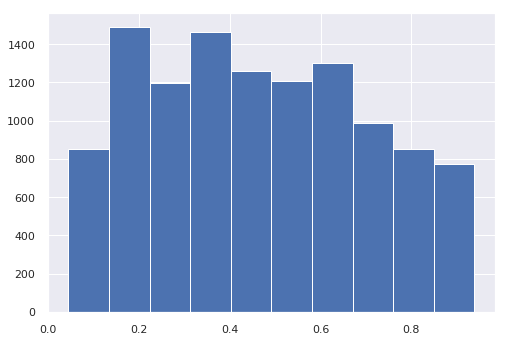

In [18]:
plt.hist(sub.Pred);

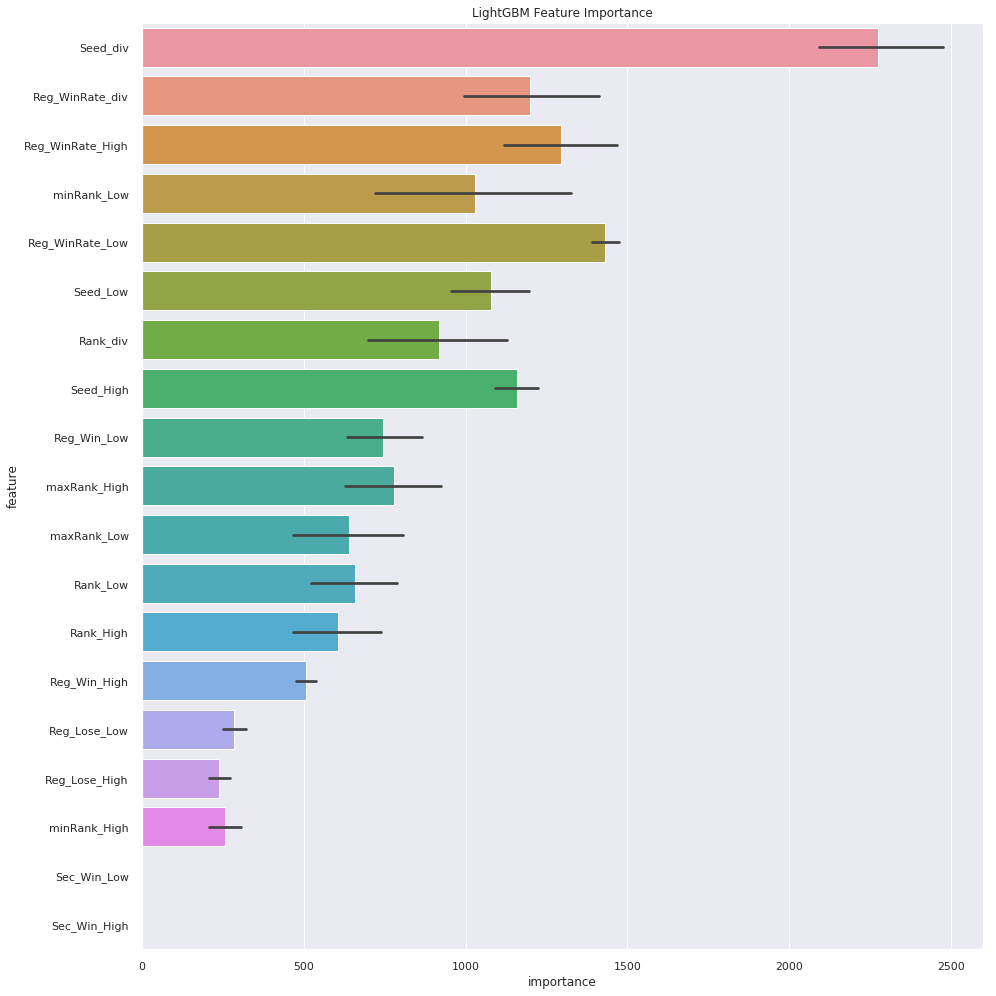

In [19]:
plt.figure(figsize=(14, 14))
sns.barplot(x="importance", y="feature", data=df_fimp.sort_values(by="importance", ascending=False))
plt.title("LightGBM Feature Importance")
plt.tight_layout()

In [20]:
sub[sub.Season == 2019]

,TeamID_Low,TeamID_High,Season,Seed_Low,Seed_dif,Seed_div,Seed_High,Seed_1ago_Low,Seed_1ago_High,Seed_prog_Low,Seed_prog_High,Reg_Win_Low,Reg_Win_High,Reg_Lose_Low,Reg_Lose_High,Reg_WinRate_Low,Reg_WinRate_High,Reg_WinRate_div,Reg_WScore_Low,Reg_WScore_High,Reg_LScore_Low,Reg_LScore_High,Reg_Score_Low,Reg_Score_High,Reg_Score_div,Rank_Low,Rank_High,maxRank_Low,maxRank_High,minRank_Low,minRank_High,Rank_div,minRank_div,maxRank_div,Sec_Win_Low,Sec_Win_High,Pred
71280,1181,1277,2019,1,-1,0.500000,2,2.0,3.0,-1.0,-1.0,29,28,5.0,6.0,0.852941,0.823529,1.035714,84.37931,80.035714,78.400000,73.166667,4.0,4.0,1.000000,1.980769,6.603239,26.0,81.0,1.0,1.0,0.299969,1.000000,0.320988,NaN,NaN,0.594883
71281,1181,1261,2019,1,-2,0.333333,3,2.0,NaN,-1.0,NaN,29,26,5.0,6.0,0.852941,0.812500,1.049774,84.37931,82.153846,78.400000,78.000000,4.0,5.0,0.800000,1.980769,26.874220,26.0,83.0,1.0,4.0,0.073705,0.250000,0.313253,NaN,NaN,0.637713
71282,1181,1439,2019,1,-3,0.250000,4,2.0,8.0,-1.0,-4.0,29,24,5.0,8.0,0.852941,0.750000,1.137255,84.37931,77.708333,78.400000,62.875000,4.0,4.0,1.000000,1.980769,14.323887,26.0,51.0,1.0,1.0,0.138284,1.000000,0.509804,NaN,NaN,0.765483
71283,1181,1280,2019,1,-4,0.200000,5,2.0,NaN,-1.0,NaN,29,23,5.0,10.0,0.852941,0.696970,1.223785,84.37931,79.652174,78.400000,72.000000,4.0,4.0,1.000000,1.980769,24.789907,26.0,134.0,1.0,6.0,0.079902,0.166667,0.194030,NaN,NaN,0.802663
71284,1181,1268,2019,1,-5,0.166667,6,2.0,NaN,-1.0,NaN,29,22,5.0,10.0,0.852941,0.687500,1.240642,84.37931,75.409091,78.400000,62.400000,4.0,4.0,1.000000,1.980769,25.674587,26.0,70.0,1.0,6.0,0.077149,0.166667,0.371429,NaN,NaN,0.827603
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73553,1205,1234,2019,16,6,1.600000,10,NaN,NaN,NaN,NaN,20,22,11.0,11.0,0.645161,0.666667,0.967742,77.65000,83.181818,72.363636,68.545455,4.0,4.0,1.000000,182.880130,33.105046,305.0,153.0,3.0,3.0,5.524237,1.000000,1.993464,NaN,NaN,0.247510
73554,1205,1388,2019,16,5,1.454545,11,NaN,NaN,NaN,NaN,20,22,11.0,11.0,0.645161,0.666667,0.967742,77.65000,76.590909,72.363636,65.545455,4.0,4.0,1.000000,182.880130,56.774194,305.0,194.0,3.0,11.0,3.221184,0.272727,1.572165,NaN,NaN,0.260655
73555,1205,1332,2019,16,4,1.333333,12,NaN,NaN,NaN,NaN,20,23,11.0,12.0,0.645161,0.657143,0.981767,77.65000,73.478261,72.363636,64.750000,4.0,3.0,1.333333,182.880130,61.149573,305.0,162.0,3.0,7.0,2.990702,0.428571,1.882716,NaN,NaN,0.275155
73556,1205,1414,2019,16,3,1.230769,13,NaN,NaN,NaN,NaN,20,29,11.0,5.0,0.645161,0.852941,0.756396,77.65000,73.793103,72.363636,64.800000,4.0,4.0,1.000000,182.880130,92.139309,305.0,171.0,3.0,28.0,1.984822,0.107143,1.783626,NaN,NaN,0.306222


In [21]:
score = train_pred[(train_pred.Season >= 2015) & (train_pred.Season <= 2019)].copy()
score = score.merge(sub,on=["Season","TeamID_Low","TeamID_High"],how="left")
print(score.loc[:,["target","Pred"]].head(100))

    target      Pred
0      1.0  0.381387
1      0.0  0.449671
2      0.0  0.380030
3      0.0  0.385109
4      1.0  0.919711
5      1.0  0.666285
6      1.0  0.620308
7      1.0  0.450636
8      0.0  0.116008
9      0.0  0.650022
10     0.0  0.085508
11     0.0  0.437729
12     0.0  0.107162
13     0.0  0.102509
14     1.0  0.439581
15     0.0  0.817017
16     0.0  0.636416
17     0.0  0.439577
18     0.0  0.072912
19     0.0  0.347108
20     1.0  0.342974
21     1.0  0.917694
22     1.0  0.911239
23     0.0  0.380491
24     1.0  0.922434
25     1.0  0.744783
26     1.0  0.803062
27     0.0  0.349161
28     1.0  0.657001
29     0.0  0.094306
30     0.0  0.379860
31     1.0  0.511702
32     0.0  0.073588
33     0.0  0.224070
34     0.0  0.339086
35     0.0  0.066377
36     1.0  0.800484
37     0.0  0.195668
38     1.0  0.161868
39     0.0  0.439985
40     0.0  0.386941
41     0.0  0.244872
42     0.0  0.415892
43     0.0  0.174968
44     1.0  0.825821
45     1.0  0.778045
46     1.0  0

In [22]:
print(log_loss(score.target,score.Pred))

0.5353174031112891


In [23]:
sub["ID"] = sub["Season"].astype(str).str.cat(sub["TeamID_Low"].astype(str),sep="_").str.cat(sub["TeamID_High"].astype(str),sep="_")
sub = sub.loc[:,["ID","Pred"]]

In [24]:
sub.to_csv("submission.csv",index=False)
sub

,ID,Pred
62168,2015_1437_1438,0.558627
62169,2015_1437_1461,0.888290
62170,2015_1437_1452,0.777154
62171,2015_1437_1455,0.794084
62172,2015_1437_1458,0.541494
...,...,...
73553,2019_1205_1234,0.247510
73554,2019_1205_1388,0.260655
73555,2019_1205_1332,0.275155
73556,2019_1205_1414,0.306222
